In [7]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.io as isoio
import isolearn.keras as isol

import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor

from scipy.stats import pearsonr, spearmanr

import seaborn as sns

from matplotlib import colors

import editdistance

def subselect_list(li, ixs) :
    return [
        li[ixs[k]] for k in range(len(ixs))
    ]

class IdentityEncoder(iso.SequenceEncoder) :
    
    def __init__(self, seq_len, channel_map) :
        super(IdentityEncoder, self).__init__('identity', (seq_len, len(channel_map)))
        
        self.seq_len = seq_len
        self.n_channels = len(channel_map)
        self.encode_map = channel_map
        self.decode_map = {
            nt: ix for ix, nt in self.encode_map.items()
        }
    
    def encode(self, seq) :
        encoding = np.zeros((self.seq_len, self.n_channels))
        
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.

        return encoding
    
    def encode_inplace(self, seq, encoding) :
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.
    
    def encode_inplace_sparse(self, seq, encoding_mat, row_index) :
        raise NotImplementError()
    
    def decode(self, encoding) :
        seq = ''
    
        for pos in range(0, encoding.shape[0]) :
            argmax_nt = np.argmax(encoding[pos, :])
            max_nt = np.max(encoding[pos, :])
            seq += self.decode_map[argmax_nt]

        return seq
    
    def decode_sparse(self, encoding_mat, row_index) :
        raise NotImplementError()

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
from keras.utils import Sequence
import h5py
import os

#SV40 AVG Measurement
target_output_ix = 5

class MPRADataLoader(Sequence):
    def __init__(self, file_path, batch_size=32) :
        self.batch_size = batch_size
        self.fname = file_path

        with h5py.File(self.fname, 'r') as hf:
            self.max_batches = hf['X']['sequence'].shape[0]//self.batch_size

    def __len__(self):
        return self.max_batches

    def __getitem__(self, idx):
        start_idx = self.batch_size*idx
        end_idx = start_idx + self.batch_size
        with h5py.File(self.fname, 'r') as hf:
            x, y = hf['X']['sequence'][start_idx:end_idx], hf['Y']['output'][start_idx:end_idx]
       
        return x,y 

with h5py.File("../../../../seqprop/examples/mpradragonn/mpradragonn_traindata.hdf5", 'r') as hf:
    x_train, y_train = hf['X']['sequence'][:], hf['Y']['output'][:]

x_train = np.expand_dims(x_train, axis=1)
y_train = y_train[:, target_output_ix]

with h5py.File("../../../../seqprop/examples/mpradragonn/mpradragonn_testdata.hdf5", 'r') as hf:
    x_test, y_test = hf['X']['sequence'][:], hf['Y']['output'][:]

x_test = np.expand_dims(x_test, axis=1)
y_test = y_test[:, target_output_ix]

print(x_train.shape)
print(x_test.shape)


(914348, 1, 145, 4)
(10130, 1, 145, 4)


In [4]:
#Reconstruct sequences from pre-computed one-hot-coded matrices

use_cached_version = True

sequence_encoder = IdentityEncoder(145, {'A':0, 'C':1, 'G':2, 'T':3})

seqs_train = None
seqs_test = None

if use_cached_version :
    seqs_train = pd.read_csv("mpradragonn_seqs_train.csv", sep="\t")["seq"].values.tolist()
    seqs_test = pd.read_csv("mpradragonn_seqs_test.csv", sep="\t")["seq"].values.tolist()
else :
    seqs_train = [sequence_encoder.decode(x_train[i, 0]) for i in range(x_train.shape[0])]
    seqs_test = [sequence_encoder.decode(x_test[i, 0]) for i in range(x_test.shape[0])]

    seqs_train_df = pd.DataFrame({'seq' : seqs_train})
    seqs_train_df.to_csv("mpradragonn_seqs_train.csv", sep="\t", index=False)

    seqs_test_df = pd.DataFrame({'seq' : seqs_test})
    seqs_test_df.to_csv("mpradragonn_seqs_test.csv", sep="\t", index=False)

print("len(seqs_train) = " + str(len(seqs_train)))
print("len(seqs_test) = " + str(len(seqs_test)))


len(seqs_train) = 914348
len(seqs_test) = 10130


In [5]:
#Compute k-mer count matrices

use_cached_version = True

sparse_mer2_encoder = isol.SparseBatchEncoder(isol.NMerEncoder(n_mer_len=2, count_n_mers=True))
sparse_mer3_encoder = isol.SparseBatchEncoder(isol.NMerEncoder(n_mer_len=3, count_n_mers=True))
sparse_mer4_encoder = isol.SparseBatchEncoder(isol.NMerEncoder(n_mer_len=4, count_n_mers=True))
sparse_mer5_encoder = isol.SparseBatchEncoder(isol.NMerEncoder(n_mer_len=5, count_n_mers=True))
sparse_mer6_encoder = isol.SparseBatchEncoder(isol.NMerEncoder(n_mer_len=6, count_n_mers=True))
sparse_mer7_encoder = isol.SparseBatchEncoder(isol.NMerEncoder(n_mer_len=7, count_n_mers=True))
sparse_mer8_encoder = isol.SparseBatchEncoder(isol.NMerEncoder(n_mer_len=8, count_n_mers=True))

mer2_train = None
mer3_train = None
mer4_train = None
mer5_train = None
mer6_train = None
mer7_train = None
mer8_train = None

mer2_test = None
mer3_test = None
mer4_test = None
mer5_test = None
mer6_test = None
mer7_test = None
mer8_test = None

if use_cached_version :
    mer2_train = spio.loadmat("mpradragon_mer2_counts_train.mat")["mer2_train"]
    mer3_train = spio.loadmat("mpradragon_mer3_counts_train.mat")["mer3_train"]
    mer4_train = spio.loadmat("mpradragon_mer4_counts_train.mat")["mer4_train"]
    mer5_train = spio.loadmat("mpradragon_mer5_counts_train.mat")["mer5_train"]
    mer6_train = spio.loadmat("mpradragon_mer6_counts_train.mat")["mer6_train"]
    mer7_train = spio.loadmat("mpradragon_mer7_counts_train.mat")["mer7_train"]
    mer8_train = spio.loadmat("mpradragon_mer8_counts_train.mat")["mer8_train"]

    mer2_test = spio.loadmat("mpradragon_mer2_counts_test.mat")["mer2_test"]
    mer3_test = spio.loadmat("mpradragon_mer3_counts_test.mat")["mer3_test"]
    mer4_test = spio.loadmat("mpradragon_mer4_counts_test.mat")["mer4_test"]
    mer5_test = spio.loadmat("mpradragon_mer5_counts_test.mat")["mer5_test"]
    mer6_test = spio.loadmat("mpradragon_mer6_counts_test.mat")["mer6_test"]
    mer7_test = spio.loadmat("mpradragon_mer7_counts_test.mat")["mer7_test"]
    mer8_test = spio.loadmat("mpradragon_mer8_counts_test.mat")["mer8_test"]
else :
    mer2_train = sparse_mer2_encoder(seqs_train)
    mer3_train = sparse_mer3_encoder(seqs_train)
    mer4_train = sparse_mer4_encoder(seqs_train)
    mer5_train = sparse_mer5_encoder(seqs_train)
    mer6_train = sparse_mer6_encoder(seqs_train)
    mer7_train = sparse_mer7_encoder(seqs_train)
    mer8_train = sparse_mer8_encoder(seqs_train)

    mer2_test = sparse_mer2_encoder(seqs_test)
    mer3_test = sparse_mer3_encoder(seqs_test)
    mer4_test = sparse_mer4_encoder(seqs_test)
    mer5_test = sparse_mer5_encoder(seqs_test)
    mer6_test = sparse_mer6_encoder(seqs_test)
    mer7_test = sparse_mer7_encoder(seqs_test)
    mer8_test = sparse_mer8_encoder(seqs_test)

    spio.savemat("mpradragon_mer2_counts_train.mat", {"mer2_train" : mer2_train})
    spio.savemat("mpradragon_mer3_counts_train.mat", {"mer3_train" : mer3_train})
    spio.savemat("mpradragon_mer4_counts_train.mat", {"mer4_train" : mer4_train})
    spio.savemat("mpradragon_mer5_counts_train.mat", {"mer5_train" : mer5_train})
    spio.savemat("mpradragon_mer6_counts_train.mat", {"mer6_train" : mer6_train})
    spio.savemat("mpradragon_mer7_counts_train.mat", {"mer7_train" : mer7_train})
    spio.savemat("mpradragon_mer8_counts_train.mat", {"mer8_train" : mer8_train})

    spio.savemat("mpradragon_mer2_counts_test.mat", {"mer2_test" : mer2_test})
    spio.savemat("mpradragon_mer3_counts_test.mat", {"mer3_test" : mer3_test})
    spio.savemat("mpradragon_mer4_counts_test.mat", {"mer4_test" : mer4_test})
    spio.savemat("mpradragon_mer5_counts_test.mat", {"mer5_test" : mer5_test})
    spio.savemat("mpradragon_mer6_counts_test.mat", {"mer6_test" : mer6_test})
    spio.savemat("mpradragon_mer7_counts_test.mat", {"mer7_test" : mer7_test})
    spio.savemat("mpradragon_mer8_counts_test.mat", {"mer8_test" : mer8_test})

print("mer2_train.shape = " + str(mer2_train.shape))
print("mer2_test.shape = " + str(mer2_test.shape))


mer2_train.shape = (914348, 16)
mer2_test.shape = (10130, 16)


In [6]:
#Create concatenated (log) feature data matrix

mer_train = sp.csr_matrix(sp.hstack([
    mer2_train,
    mer3_train,
    mer4_train,
    mer5_train,
    mer6_train,
    mer7_train,
    mer8_train,
]))

mer_test = sp.csr_matrix(sp.hstack([
    mer2_test,
    mer3_test,
    mer4_test,
    mer5_test,
    mer6_test,
    mer7_test,
    mer8_test,
]))


log_mer_train = sp.coo_matrix(mer_train.copy())
log_mer_train.data = np.log2(1. + log_mer_train.data)
log_mer_train = sp.csr_matrix(log_mer_train)

log_mer_test = sp.coo_matrix(mer_test.copy())
log_mer_test.data = np.log2(1. + log_mer_test.data)
log_mer_test = sp.csr_matrix(log_mer_test)

print("log_mer_train.shape = " + str(log_mer_train.shape))
print("log_mer_test.shape = " + str(log_mer_test.shape))


log_mer_train.shape = (914348, 87376)
log_mer_test.shape = (10130, 87376)


In [9]:
#Train a sparse k-mer lasso model (k-mer feature selection step)

use_cached_version = True

n_train_subset = 100000
l1_alpha = 0.0013

if use_cached_version :
    mer_lasso = pickle.load(open("mpradragonn_mer2345678_lasso_l1_alpha_" + str(l1_alpha).replace(".", "_") + "_n_train_" + str(n_train_subset) + ".pickle", "rb"))["mer6_lasso"]
else :
    shuffle_index = np.arange(log_mer_train.shape[0])
    np.random.shuffle(shuffle_index)

    mer_lasso = linear_model.Lasso(alpha=l1_alpha).fit(log_mer_train[shuffle_index[:n_train_subset]], y_train[shuffle_index[:n_train_subset]])
    
    pickle.dump({
        "mer6_lasso" : mer_lasso,
        "mer6_lasso.intercept_" : mer_lasso.intercept_,
        "mer6_lasso.coef_" : mer_lasso.coef_
    }, open("mpradragonn_mer2345678_lasso_l1_alpha_" + str(l1_alpha).replace(".", "_") + "_n_train_" + str(n_train_subset) + ".pickle", "wb"))

print("# nonzero coefficients (lasso) = " + str(len(mer_lasso.coef_[mer_lasso.coef_ != 0.])))


# nonzero coefficients (lasso) = 505


In [12]:
#Train an L2-regularized linear model using features discovered earlier (de-biasing step)

use_cached_version = True

l2_alpha = 2000.0

nonzero_feat_ix = np.nonzero(mer_lasso.coef_)[0]

if use_cached_version :
    mer_linear = pickle.load(open("mpradragonn_mer2345678_linear_l2_alpha_" + str(l2_alpha).replace(".", "_") + ".pickle", "rb"))["mer6_linear"]
else :
    mer_linear = linear_model.Ridge(alpha=l2_alpha).fit(log_mer_train[:, nonzero_feat_ix], y_train[:])
    
    pickle.dump({
        "mer6_linear" : mer_linear,
        "nonzero_feat_ix" : nonzero_feat_ix,
        "mer6_linear.intercept_" : mer_linear.intercept_,
        "mer6_linear.coef_" : mer_linear.coef_
    }, open("mpradragonn_mer2345678_linear_l2_alpha_" + str(l2_alpha).replace(".", "_") + ".pickle", "wb"))

print("# nonzero coeffs = " + str(len(mer_linear.coef_[mer_linear.coef_ != 0.])))


# nonzero coeffs = 505


-- K-mer Linear Model (Training data) --
pearson-r correlation = 0.1739
pearson-r p = 0.0


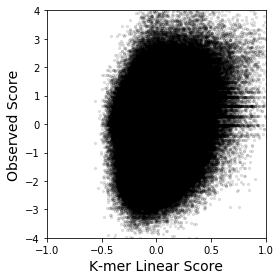

-- K-mer Linear Model (Test data) --
pearson-r correlation = 0.1285
pearson-r p = 0.0


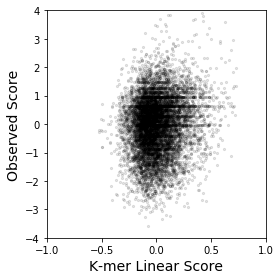

In [16]:
#Predict on data using linear k-mer model

print("-- K-mer Linear Model (Training data) --")

y_train_hat = mer_linear.predict(log_mer_train[:, nonzero_feat_ix])

print("pearson-r correlation = " + str(round(pearsonr(y_train_hat, y_train)[0], 4)))
print("pearson-r p = " + str(round(pearsonr(y_train_hat, y_train)[1], 4)))

f = plt.figure(figsize=(4, 4))

plt.scatter(y_train_hat, y_train, s=5, color='black', alpha=0.1)

plt.xlim(-1, 1)
plt.ylim(-4, 4)

plt.xlabel("K-mer Linear Score", fontsize=14)
plt.ylabel("Observed Score", fontsize=14)

plt.tight_layout()
plt.show()

print("-- K-mer Linear Model (Test data) --")

y_test_hat = mer_linear.predict(log_mer_test[:, nonzero_feat_ix])

print("pearson-r correlation = " + str(round(pearsonr(y_test_hat, y_test)[0], 4)))
print("pearson-r p = " + str(round(pearsonr(y_train_hat, y_train)[1], 4)))

f = plt.figure(figsize=(4, 4))

plt.scatter(y_test_hat, y_test, s=5, color='black', alpha=0.1)

plt.xlim(-1, 1)
plt.ylim(-4, 4)

plt.xlabel("K-mer Linear Score", fontsize=14)
plt.ylabel("Observed Score", fontsize=14)

plt.tight_layout()
plt.show()


In [17]:
#Load simpler MPRA-DragoNN conv network (published model from Kundaje Lab)

mpradragonn_smaller = Sequential()

mpradragonn_smaller.add(Conv1D(120, 5, activation='relu', input_shape=(145, 4), name='dragonn_conv1d_1_copy'))
mpradragonn_smaller.add(BatchNormalization(name='dragonn_batchnorm_1_copy'))
mpradragonn_smaller.add(Dropout(0.1, name='dragonn_dropout_1_copy'))

mpradragonn_smaller.add(Conv1D(120, 5, activation='relu', name='dragonn_conv1d_2_copy'))
mpradragonn_smaller.add(BatchNormalization(name='dragonn_batchnorm_2_copy'))
mpradragonn_smaller.add(Dropout(0.1, name='dragonn_dropout_2_copy'))

mpradragonn_smaller.add(Conv1D(120, 5, activation='relu', name='dragonn_conv1d_3_copy'))
mpradragonn_smaller.add(BatchNormalization(name='dragonn_batchnorm_3_copy'))
mpradragonn_smaller.add(Dropout(0.1, name='dragonn_dropout_3_copy'))

mpradragonn_smaller.add(Flatten())
mpradragonn_smaller.add(Dense(12, activation='linear', name='dragonn_dense_1_copy'))

mpradragonn_smaller.compile(
    loss= "mean_squared_error",
    optimizer=keras.optimizers.SGD(lr=0.1)
)

model_path = '../pretrained_conv_model.hdf5'

mpradragonn_smaller.load_weights(model_path)


-- MPRA-Dragonn (Training data) --
pearson-r correlation = 0.2369
pearson-r p = 0.0


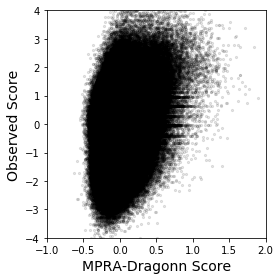

-- MPRA-Dragonn (Test data) --
pearson-r correlation = 0.143
pearson-r p = 0.0


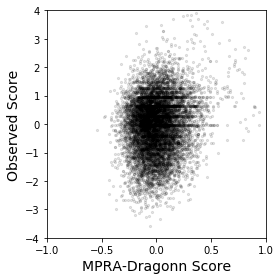

In [22]:
#Predict on data using MPRA-Dragonn

print("-- MPRA-Dragonn (Training data) --")

y_train_hat = mpradragonn_smaller.predict(x=[x_train[:, 0, :, :]], verbose=True, batch_size=32)[:, 5]

print("pearson-r correlation = " + str(round(pearsonr(y_train_hat, y_train)[0], 4)))
print("pearson-r p = " + str(round(pearsonr(y_train_hat, y_train)[1], 4)))

f = plt.figure(figsize=(4, 4))

plt.scatter(y_train_hat, y_train, s=5, color='black', alpha=0.1)

plt.xlim(-1, 2)
plt.ylim(-4, 4)

plt.xlabel("MPRA-Dragonn Score", fontsize=14)
plt.ylabel("Observed Score", fontsize=14)

plt.tight_layout()
plt.show()

print("-- MPRA-Dragonn (Test data) --")

y_test_hat = mpradragonn_smaller.predict(x=[x_test[:, 0, :, :]], verbose=True, batch_size=32)[:, 5]

print("pearson-r correlation = " + str(round(pearsonr(y_test_hat, y_test)[0], 4)))
print("pearson-r p = " + str(round(pearsonr(y_train_hat, y_train)[1], 4)))

f = plt.figure(figsize=(4, 4))

plt.scatter(y_test_hat, y_test, s=5, color='black', alpha=0.1)

plt.xlim(-1, 1)
plt.ylim(-4, 4)

plt.xlabel("MPRA-Dragonn Score", fontsize=14)
plt.ylabel("Observed Score", fontsize=14)

plt.tight_layout()
plt.show()


In [23]:
#Train a boosted k-mer ensemble using features discovered earlier

use_cached_version = True

n_estimators = 256
max_depth = 5

nonzero_feat_ix = np.nonzero(mer_lasso.coef_)[0]

if use_cached_version :
    boosted_grad = pickle.load(open("mpradragonn_mer2345678_boosted_grad_n_estimators_" + str(n_estimators) + "_max_depth_" + str(max_depth) + "_n_features_" + str(len(nonzero_feat_ix)) + ".pickle", "rb"))["boosted_grad"]
else :
    boosted_grad = GradientBoostingRegressor(
        n_estimators=n_estimators,
        learning_rate=0.1,
        max_depth=max_depth,
        loss='ls',
        verbose=1
    ).fit(
        np.array(log_mer_train[:, nonzero_feat_ix].todense()),
        y_train
    )
    
    pickle.dump({
        "boosted_grad" : boosted_grad
    }, open("mpradragonn_mer2345678_boosted_grad_n_estimators_" + str(n_estimators) + "_max_depth_" + str(max_depth) + "_n_features_" + str(len(nonzero_feat_ix)) + ".pickle", "wb"))

print(boosted_grad)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=256, presort='auto', random_state=None,
             subsample=1.0, verbose=1, warm_start=False)


-- Boosted K-mer Model (Training data) --
pearson-r correlation = 0.2658
pearson-r p = 0.0


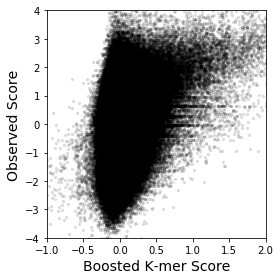

-- Boosted K-mer Model (Test data) --
pearson-r correlation = 0.1494
pearson-r p = 0.0


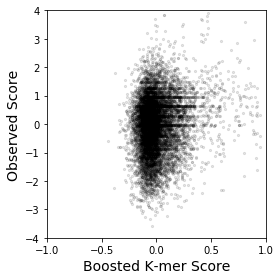

In [24]:
#Predict on data using boosted k-mer model

print("-- Boosted K-mer Model (Training data) --")

y_train_hat = boosted_grad.predict(log_mer_train[:, nonzero_feat_ix])

print("pearson-r correlation = " + str(round(pearsonr(y_train_hat, y_train)[0], 4)))
print("pearson-r p = " + str(round(pearsonr(y_train_hat, y_train)[1], 4)))

f = plt.figure(figsize=(4, 4))

plt.scatter(y_train_hat, y_train, s=5, color='black', alpha=0.1)

plt.xlim(-1, 2)
plt.ylim(-4, 4)

plt.xlabel("Boosted K-mer Score", fontsize=14)
plt.ylabel("Observed Score", fontsize=14)

plt.tight_layout()
plt.show()

print("-- Boosted K-mer Model (Test data) --")

y_test_hat = boosted_grad.predict(log_mer_test[:, nonzero_feat_ix])

print("pearson-r correlation = " + str(round(pearsonr(y_test_hat, y_test)[0], 4)))
print("pearson-r p = " + str(round(pearsonr(y_train_hat, y_train)[1], 4)))

f = plt.figure(figsize=(4, 4))

plt.scatter(y_test_hat, y_test, s=5, color='black', alpha=0.1)

plt.xlim(-1, 1)
plt.ylim(-4, 4)

plt.xlabel("Boosted K-mer Score", fontsize=14)
plt.ylabel("Observed Score", fontsize=14)

plt.tight_layout()
plt.show()
